In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly
import holidays
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation, performance_metrics


from prophet.serialize import model_to_json, model_from_json

def evaluate_model(model, historical_data):

    total_days = (historical_data['ds'].max() - historical_data['ds'].min()).days
    

    initial = min(730, total_days // 3)  # Use 1/3 of data or 730 days, whichever is smaller
    

    period = min(180, total_days // 10)  # Use 1/10 of data or 180 days, whichever is smaller
    

    horizon = '14 days'
    try:

        cv_results = cross_validation(model, initial=f'{initial} days', period=f'{period} days', horizon=horizon)
        

        metrics = performance_metrics(cv_results)
        

        mape = np.mean(np.abs((cv_results['y'] - cv_results['yhat']) / cv_results['y'])) * 100
        

        rmse = np.sqrt(metrics['mse'].mean())
        
    except ValueError as e:
        print(f"Warning: Not enough data for cross-validation. Error: {str(e)}")
        mape = rmse = float('nan') 
    
    return mape, rmse, horizon  

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['EffectiveDate'] = pd.to_datetime(df['EffectiveDate'])
    daily_demand = df.groupby('EffectiveDate')['Demand'].sum().reset_index()
    daily_demand = daily_demand.rename(columns={'EffectiveDate': 'ds', 'Demand': 'y'})
    return daily_demand

def create_and_fit_model(data, country_code):

    try:
        country_holidays = getattr(holidays, country_code)(years=[2023, 2024])
        holiday_df = pd.DataFrame([(date, name) for date, name in country_holidays.items()], columns=['ds', 'holiday'])
        holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
    except AttributeError:
        holiday_df = None

    model = Prophet(
        holidays=holiday_df,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        interval_width=0.95
    )
    model.fit(data)
    return model

In [4]:
historical = pd.read_csv('data/ZM.csv')
inference = pd.read_csv('data/ZM.csv.out')
country_code = 'ZM'
cv_horizon = '14 days'

In [7]:
def create_forecast_plot_inference(historical, inference, country_code, cv_horizon):
    fig = go.Figure()
    
    # Convert EffectiveDate to datetime format
    historical['EffectiveDate'] = pd.to_datetime(historical['EffectiveDate'])
    inference['EffectiveDate'] = pd.to_datetime(inference['EffectiveDate'])
    
    # Historical data
    fig.add_trace(go.Scatter(x=historical['EffectiveDate'], y=historical['Demand'], name='Historical', mode='markers', marker=dict(color='black', size=4)))
    
    # Forecast from inference
    fig.add_trace(go.Scatter(x=inference['EffectiveDate'], y=inference['mean'], name='Forecast', line=dict(color='blue')))
    
    # Confidence intervals
    fig.add_trace(go.Scatter(
        x=inference['EffectiveDate'].tolist() + inference['EffectiveDate'].tolist()[::-1],
        y=inference['p99'].tolist() + inference['p5'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='Confidence Interval'
    ))
    
    # Holidays (assuming holidays exist in the historical data)
    if 'Holidays' in historical.columns:
        holiday_dates = pd.to_datetime(historical.loc[historical['Holidays'] == True, 'EffectiveDate'])
        holiday_dates = holiday_dates[holiday_dates.isin(inference['EffectiveDate'])]
        if not holiday_dates.empty:
            holiday_demands = inference.loc[inference['EffectiveDate'].isin(holiday_dates), 'mean'].tolist()
            fig.add_trace(go.Scatter(x=holiday_dates, y=holiday_demands, mode='markers', marker=dict(symbol='star', size=10, color='red'), name='Holidays'))
    
    # Highlight unseen data
    last_historical_date = historical['EffectiveDate'].max()
    cv_days = int(cv_horizon.split()[0]) if isinstance(cv_horizon, str) else int(cv_horizon)
    unseen_start = last_historical_date - pd.Timedelta(days=cv_days)
    fig.add_vrect(x0=unseen_start, x1=last_historical_date, 
                  fillcolor="LightSalmon", opacity=0.5, 
                  layer="below", line_width=0,
                  annotation_text="Unseen Data", annotation_position="top left")
    
    # Update layout
    fig.update_layout(
        height=600, 
        title_text=f"Demand Forecast for {country_code}", 
        showlegend=True,
        xaxis_title="Date",
        yaxis_title="Demand"
    )
    
    # Set y-axis range manually
    fig.update_yaxes(range=[0, 1000000])  # Change [0, 1000] to your desired lower and upper bounds

    return fig


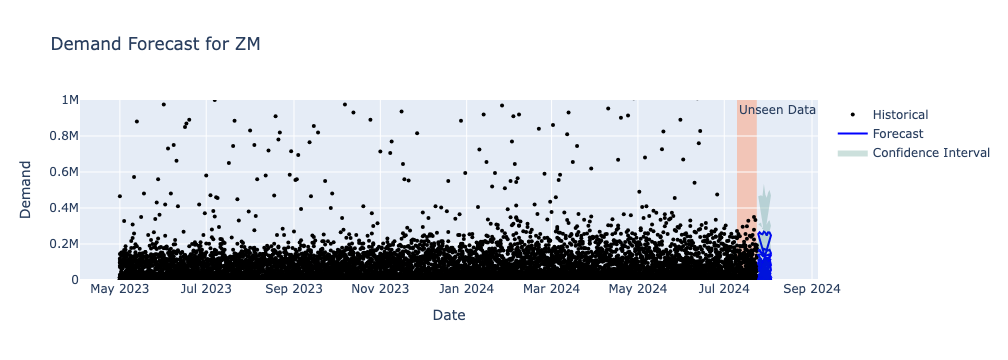

In [8]:
create_forecast_plot_inference(historical, inference, country_code, cv_horizon)

In [9]:
def create_forecast_plot(historical, forecast, model, country_code, mape, rmse, cv_horizon):
    fig = go.Figure()
    
    # Historical data
    fig.add_trace(go.Scatter(x=historical['ds'], y=historical['y'], name='Historical', mode='markers', marker=dict(color='black', size=4)))
    
    # Forecast
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast', line=dict(color='blue')))
    
    # Confidence intervals
    fig.add_trace(go.Scatter(
        x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
        y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='Confidence Interval'
    ))
    
    # Holidays
    if model.holidays is not None:
        holiday_dates = pd.to_datetime(model.holidays['ds'])
        holiday_dates = holiday_dates[holiday_dates.isin(forecast['ds'])]
        if not holiday_dates.empty:
            holiday_demands = forecast.loc[forecast['ds'].isin(holiday_dates), 'yhat'].tolist()
            fig.add_trace(go.Scatter(x=holiday_dates, y=holiday_demands, mode='markers', marker=dict(symbol='star', size=10, color='red'), name='Holidays'))
    
    # Highlight unseen data
    last_historical_date = historical['ds'].max()
    unseen_start = last_historical_date - pd.Timedelta(days=int(cv_horizon.split()[0]))
    fig.add_vrect(x0=unseen_start, x1=last_historical_date, 
                  fillcolor="LightSalmon", opacity=0.5, 
                  layer="below", line_width=0,
                  annotation_text="Unseen Data", annotation_position="top left")
    
    # Add MAPE and RMSE to the plot
    annotation_text = f'MAPE: {mape:.2f}%<br>RMSE: {rmse:.2f}'
    fig.add_annotation(xref='paper', yref='paper', x=0.02, y=0.98,
                       text=annotation_text, showarrow=False,
                       font=dict(size=12), align='left',
                       bgcolor='rgba(255,255,255,0.8)', bordercolor='black', borderwidth=1)
    
    fig.update_layout(
        height=600, 
        title_text=f"Demand Forecast for {country_code}", 
        showlegend=True,
        xaxis_title="Date",
        yaxis_title="Demand"
    )
    
    return fig

In [13]:
# Main processing loop
data_dir = 'data/cash/'
output_dir = 'data/cash/output/'
os.makedirs(output_dir, exist_ok=True)

In [14]:
os.getcwd()

'/Users/christostrydom/github_repos/korridor_cf'

In [15]:
pd.read_csv('data/diesel/BW.csv')

,BranchId,CountryCode,CountryName,ProductId,Currency,EffectiveDate,Demand,DayOfWeekName
0,665,BW,Botswana,2094,BWP,2023-07-01,0.00,Saturday
1,706,BW,Botswana,2253,BWP,2023-07-01,0.00,Saturday
2,651,BW,Botswana,2065,BWP,2023-07-01,0.00,Saturday
3,657,BW,Botswana,2082,BWP,2023-07-01,0.00,Saturday
4,714,BW,Botswana,2285,BWP,2023-07-01,0.00,Saturday
...,...,...,...,...,...,...,...,...
10859,524,BW,Botswana,1740,BWP,2024-07-22,350.00,Monday
10860,529,BW,Botswana,1757,BWP,2024-07-22,0.00,Monday
10861,530,BW,Botswana,1748,BWP,2024-07-22,0.00,Monday
10862,527,BW,Botswana,1754,BWP,2024-07-22,5602.87,Monday


In [16]:
os.makedirs(output_dir, exist_ok=True)

In [17]:
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        country_code = filename.split('.')[0]
        file_path = os.path.join(data_dir, filename)
        
        print(f"Processing {country_code}...")
        

        daily_demand = load_and_prepare_data(file_path)
        

        model = create_and_fit_model(daily_demand, country_code)
        

        mape, rmse, cv_horizon = evaluate_model(model, daily_demand)
        
        print(f"Model Accuracy for {country_code}:")
        if np.isnan(mape) or np.isnan(rmse):
            print("Insufficient data for cross-validation")
            mape = rmse = 0  # Set to 0 for plotting purposes
        else:
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
        

        future_dates = model.make_future_dataframe(periods=14)
        forecast = model.predict(future_dates)
        

        plot = create_forecast_plot(daily_demand, forecast, model, country_code, mape, rmse, cv_horizon)
        plot_path = os.path.join(output_dir, f'{country_code}_forecast.png')
        plot.write_image(plot_path)
        

        model_path = os.path.join(output_dir, f'{country_code}_model.json')
        with open(model_path, 'w') as f:
            json.dump(model_to_json(model), f)
        

        metrics_path = os.path.join(output_dir, f'{country_code}_metrics.txt')
        with open(metrics_path, 'w') as f:
            f.write(f"MAPE: {mape:.2f}%\n")
            f.write(f"RMSE: {rmse:.2f}\n")
        
        print(f"Completed processing for {country_code}")
        print(f"Model saved to: {model_path}")
        print(f"Plot saved to: {plot_path}")
        print(f"Metrics saved to: {metrics_path}")

print("All countries processed.")

Processing ZM...


04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing


Model Accuracy for ZM:
Mean Absolute Percentage Error (MAPE): 52.46%
Root Mean Square Error (RMSE): 3069595.19
Completed processing for ZM
Model saved to: data/cash/output/ZM_model.json
Plot saved to: data/cash/output/ZM_forecast.png
Metrics saved to: data/cash/output/ZM_metrics.txt
All countries processed.
